# <center>Named Entity Recognition</center>

In [1]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [2]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras


Using TensorFlow backend.


## Hyperparameter Initialization

In [3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector   
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Reading Data

In [5]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10) 

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-eve', 'B-org', 'B-tim', 'I-gpe', 'I-tim', 'O', 'I-geo', 'B-gpe', 'I-art', 'I-per', 'B-geo', 'B-art', 'I-nat', 'I-org', 'B-per', 'B-nat', 'B-eve']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


## Data Preprocessing

In [6]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


As you can see from the output Cell above, each sentence in the dataset is represented as a list of tuple: [`(Token_1, PoS_1, Tag_1)`, ..., `(Token_n, PoS_n, Tag_n)`].

## Data Visualization

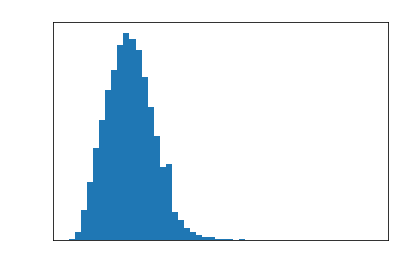

In [21]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Further Data Preprocessing

In [8]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 22215
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 11
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [  924 20337  9509  4414 25137   187 33862  3313 29467 18360 26489 24177
  6980  4795 15752 18360 20789 20337  5569  9313 16042 30300  1863 13291
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0

## Model Architecture

We will implement a model similar to Zhiheng Huang’s [Bidirectional LSTM-CRF Models for Sequence Tagging](https://arxiv.org/pdf/1508.01991v1.pdf).

<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/bilstm-crf.png" width="400" height="400" align="center"/>

*Image from [the paper](https://arxiv.org/pdf/1508.01991v1.pdf)*

In [9]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/Users/utkarsh/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/utkarsh/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 738,328
Trainable params: 738,328
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [10]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
 - 1423s - loss: 9.1097 - crf_viterbi_accuracy: 0.9001 - val_loss: 8.8954 - val_crf_viterbi_accuracy: 0.9461
Epoch 2/5
 - 1482s - loss: 8.8711 - crf_viterbi_accuracy: 0.9583 - val_loss: 8.8398 - val_crf_viterbi_accuracy: 0.9626
Epoch 3/5
 - 1448s - loss: 8.8411 - crf_viterbi_accuracy: 0.9672 - val_loss: 8.8277 - val_crf_viterbi_accuracy: 0.9652
Epoch 4/5
 - 1464s - loss: 8.8303 - crf_viterbi_accuracy: 0.9700 - val_loss: 8.8207 - val_crf_viterbi_accuracy: 0.9662
Epoch 5/5
 - 1471s - loss: 8.8243 - crf_viterbi_accuracy: 0.9720 - val_loss: 8.8194 - val_crf_viterbi_accuracy: 0.9671


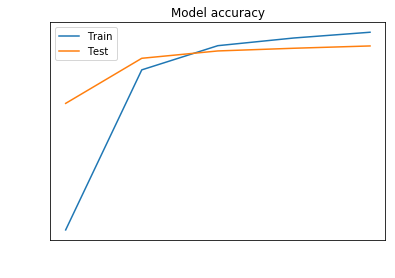

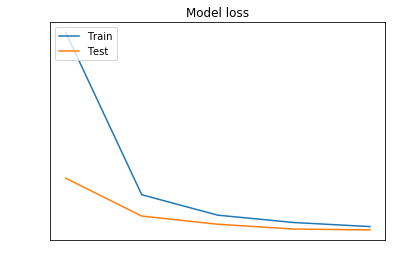

In [30]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

## Evaluation of the Model

In [12]:
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/Users/utkarsh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        42
       B-eve       0.33      0.03      0.06        31
       B-geo       0.86      0.89      0.87      3800
       B-gpe       0.97      0.93      0.95      1519
       B-nat       0.00      0.00      0.00        17
       B-org       0.74      0.72      0.73      2067
       B-per       0.85      0.81      0.83      1629
       B-tim       0.90      0.87      0.89      2047
       I-art       0.00      0.00      0.00        22
       I-eve       0.00      0.00      0.00        19
       I-geo       0.81      0.80      0.81       767
       I-gpe       1.00      0.45      0.62        22
       I-nat       0.00      0.00      0.00         6
       I-org       0.77      0.78      0.77      1692
       I-per       0.85      0.89      0.87      1647
       I-tim       0.76      0.78      0.77       672
           O       0.99      0.99      0.99     88575
         PAD       1.00    

Evaluate some samples in the test set. (At each execution it will test on a different sample).

In [14]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 3747 of 4796 (Test Set)
Word           ||True ||Pred
Iran           : B-geo B-geo
says           : O     O
the            : O     O
F-4            : B-org B-geo
Phantom        : I-org O
jet            : O     O
crashed        : O     O
at             : O     O
12.45          : B-tim B-geo
p.m.           : I-tim O
local          : O     O
time           : B-tim O
(              : O     O
915            : O     B-tim
UTC            : O     I-tim
)              : O     O
Monday         : B-tim B-tim
in             : O     O
waters         : O     O
near           : O     O
the            : O     O
Iranian        : B-gpe B-gpe
port           : O     O
city           : O     O
of             : O     O
Konarak        : B-geo O
.              : O     O
